<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [2]:
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
import glob
import csv
import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def file_to_sites(f):
    with open(f,'r') as f_open:
        cin = csv.DictReader(f_open,fieldnames=['timestamp','site'])
        next(cin, None)
        sites_data = [row for row in cin]
        times = [datetime.datetime.strptime(v['timestamp'], '%Y-%m-%d %H:%M:%S') for v in sites_data]
        sites = [v['site'] for v in sites_data]
        return sites, times

def append_new_features(session, session_times, user_id, session_length):
    unique_sites = np.unique(session)
    num_unique_sites = len(unique_sites)
    if 0 in unique_sites:
        num_unique_sites -= 1  
    start_time = np.min(session_times)
    finish_time = np.max(session_times)
    time_span = int(time.mktime(finish_time.timetuple()) - time.mktime(start_time.timetuple()))

    session.append(time_span)
    session.append(num_unique_sites)
    session.append(start_time.hour)
    session.append(start_time.weekday())
    session.append(user_id)  
    return session

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    path = path_to_csv_files + '/*csv'
    files = glob.glob(path)
    with open(site_freq_path,'rb') as site_freq_file:
        site_freq = pickle.load(site_freq_file)
    columns = ['site' + str(x + 1) for x in range(session_length)]
    columns +=  ['session_timespan','#unique_sites','start_hour','day_of_week','user_id']
    sessions_list = []
    id = 1
    for file_name in files:
            user_id = int(file_name[-8:-4])
            sites,times = file_to_sites(file_name)
            session = []
            for i in range(len(sites)):
                site = sites[i]
                site_id = site_freq[site][0]
                session.append(site_id)
                if len(session) == session_length:
                    session_times = times[i - session_length + 1 : i + 1]
                    session = append_new_features(session,session_times,user_id,session_length)
                    sessions_list.append(session)
                    session = []
            if len(session) != 0:
                session_times = times[i - len(session) + 1 : i + 1]
                session += [0] * (session_length - len(session))
                session = append_new_features(session,session_times,user_id,session_length)
                sessions_list.append(session)
                session = []
    sessions = pd.DataFrame(sessions_list, columns = columns)
    return sessions

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 7.15 s


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 19s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[['session_timespan','#unique_sites','start_hour','day_of_week']]
new_features_150users = train_data_150users[['session_timespan','#unique_sites','start_hour','day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
train_data_150users['start_hour'].median() 

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
train_data_150users['#unique_sites'].median() 

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

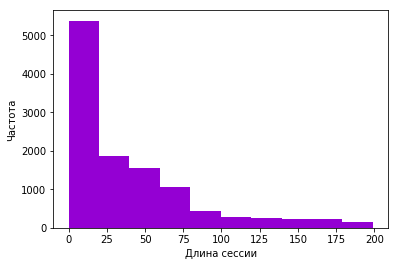

In [18]:
#ax = train_data_10users['session_timespan'].plot(kind='hist', color='darkviolet', bins=200)
#ax.set_xlim((0,200000))
indices = train_data_10users['session_timespan'] < 200
ax = train_data_10users['session_timespan'][indices].plot(kind='hist', color='darkviolet')
ax.set_xlabel(u'Длина сессии')
ax.set_ylabel(u'Частота');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

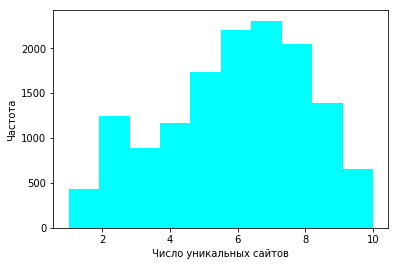

In [19]:
ax = train_data_10users['#unique_sites'].plot(kind='hist', color='aqua')
ax.set_xlabel(u'Число уникальных сайтов')
ax.set_ylabel(u'Частота');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


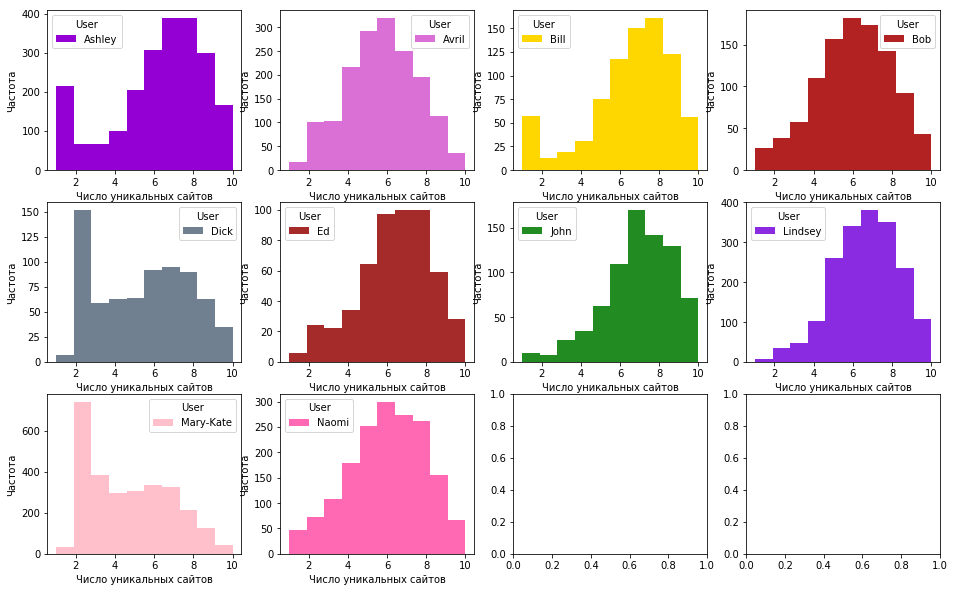

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
row = 0
col = 0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes[row,col].hist(sub_df['#unique_sites'],color=color_dic[user])
    axes[row,col].legend([user],title='User')
    axes[row,col].set_xlabel(u'Число уникальных сайтов')
    axes[row,col].set_ylabel(u'Частота');
    col += 1
    if col == 4:
        row += 1
        col = 0

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

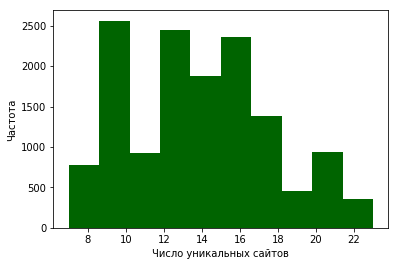

In [21]:
ax = train_data_10users['start_hour'].plot(kind='hist', color='darkgreen')
ax.set_xlabel(u'Число уникальных сайтов')
ax.set_ylabel(u'Частота');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


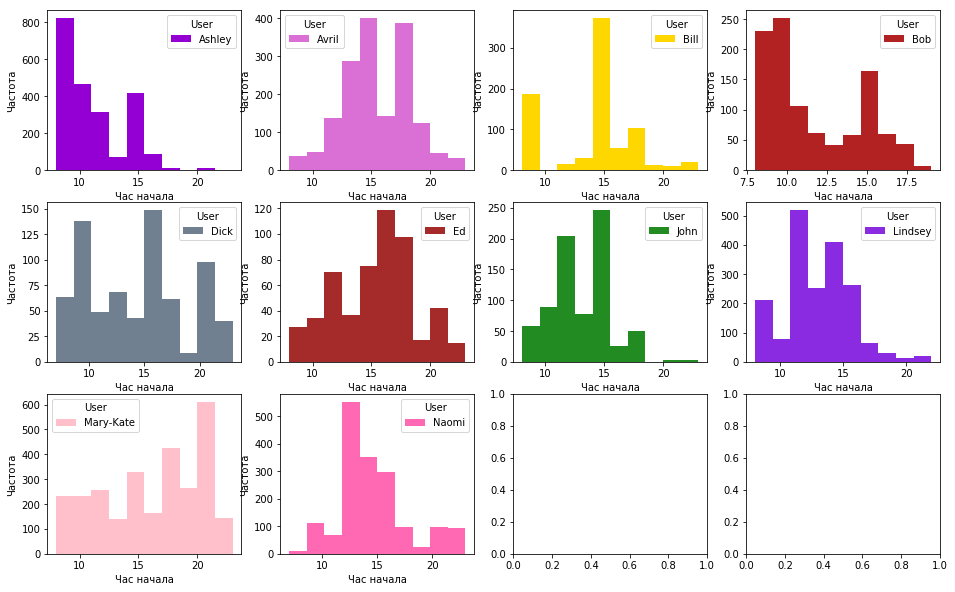

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

row = 0
col = 0
# как вариант, можно и по-другому

colors = ['Blue','Red','Green','Black','Violet','Pink','Orange','Yellow','Brown','Aqua']
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
        axes[row,col].hist(sub_df['start_hour'],color=color_dic[user])
        axes[row,col].legend([user],title='User')
        axes[row,col].set_xlabel(u'Час начала')
        axes[row,col].set_ylabel(u'Частота');
        col += 1
        if col == 4:
            row += 1
            col = 0

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

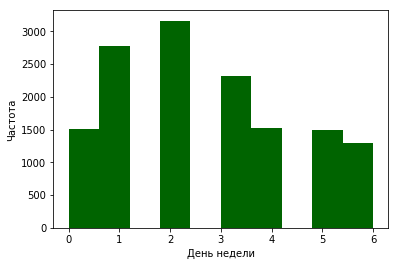

In [23]:
ax = train_data_10users['day_of_week'].plot(kind='hist', color='darkgreen')
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Частота');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


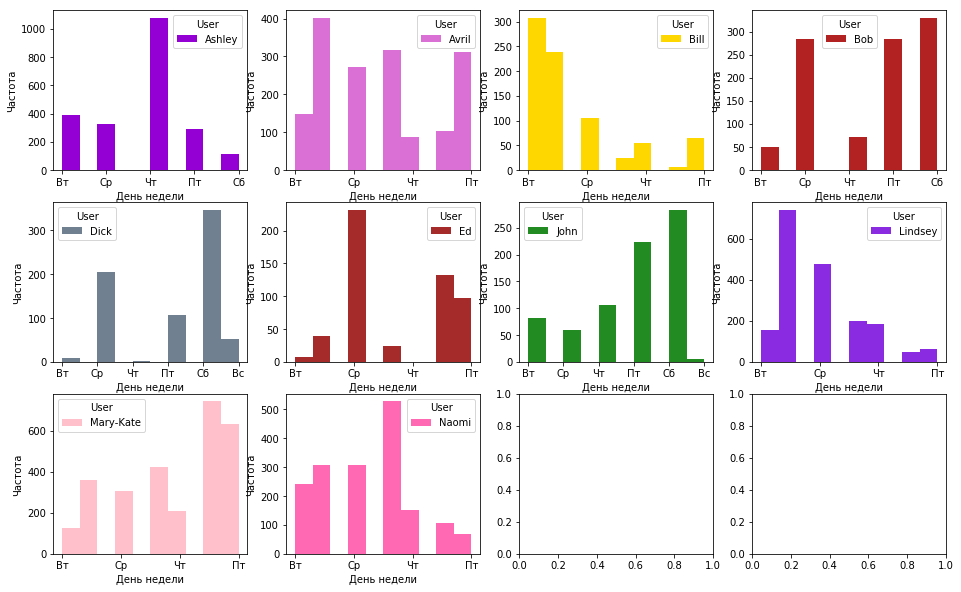

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

row = 0
col = 0
# как вариант, можно и по-другому

colors = ['Blue','Red','Green','Black','Violet','Pink','Orange','Yellow','Brown','Aqua']
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
        axes[row,col].hist(sub_df['day_of_week'],color=color_dic[user])
        axes[row,col].legend([user],title='User')
        axes[row,col].set_xlabel(u'День недели')
        axes[row,col].set_ylabel(u'Частота');
        axes[row,col].set_xticklabels([u'Пн',u'Вт',u'Ср',u'Чт',u'Пт',u'Сб',u'Вс'])
        col += 1
        if col == 4:
            row += 1
            col = 0

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

По числу уникальных сайтов можно визуально заметить следующие особенности:
У Ashley, Dick, Mary-Kate, Bill имеется вид в виде сессий с 1-2 уникальными сайтами. При этом в остальном распределение Dick и Mary-Kate похоже на остальных пользователей. Все остальные пользователи имеют примерно одинаковый вид распределений с некоторым пиком и постепенно уменьшающимися хвостами.

По часу начала получаются довольно разные распределения. У всех пользователей есть несколько пиковых часов.

По дням недели также распределения разные. При этом у Bob-а есть 3 примерно равных выраженных пика. У Bill-а и Lindsey в течение недели активность снижается. У John за небольшим исключением 


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [25]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users_opt.pkl'),'rb') as site_freq_file:
    site_freq_10users = pickle.load(site_freq_file)

In [26]:
descending_items = sorted(site_freq_10users.items(), key=lambda s: s[1][1], reverse=True)
print descending_items[0][0]

s.youtube.com


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_freqs = [x[1][1] for x in descending_items[:10]]
top10_sites = [x[0] for x in descending_items[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

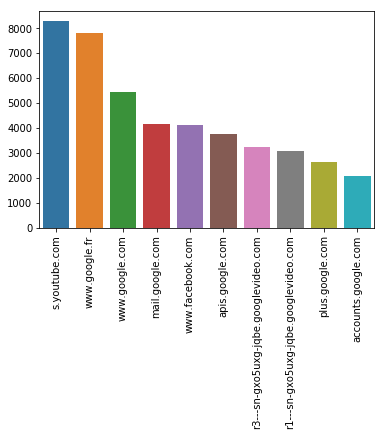

In [28]:
ax = sns.barplot(top10_sites, top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Будем добавлять признаки: средняя популярность посещенных сайтов в сессии; частота посещения социальных сетей; частота посещения поисковых сайтов.

In [29]:
def site_freq_to_id_name_freq(site_freq_path):
    with open(site_freq_path,'rb') as site_freq_file:
        site_freq = pickle.load(site_freq_file)
    res = {}
    for key in site_freq:
        res[site_freq[key][0]] = (key,site_freq[key][1])
    return res

In [30]:
id_name_freq_toy = site_freq_to_id_name_freq(os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'))

In [54]:
social_networks = frozenset(['ar-ar.facebook.com',
'connect.facebook.net',
'facebook.com',
'facebook.fr',
'fr-fr.facebook.com',
'fr.facebook.com',
'l.facebook.com',
'login.vk.com',
'm.facebook.com',
'static-0.facebook.com',
'vk.com',
'www.facebook.com',
'www.facebook.fr'])
search_engines = frozenset(['google.com',
'google.com.pe',
'google.fr',
'google.ru',
'ipv4.google.com',
'm.google.com',
'mt.google.com',
'translate.google.ru',
'www.google.be',
'www.google.bi',
'www.google.bj',
'www.google.ca',
'www.google.cd',
'www.google.ch',
'www.google.cn',
'www.google.co.in',
'www.google.co.ma',
'www.google.co.ma',
'www.google.co.uk',
'www.google.com',
'www.google.com',
'www.google.com.br',
'www.google.com.cn',
'www.google.com.hk',
'www.google.com.pe',
'www.google.com.pe',
'www.google.de',
'www.google.de',
'www.google.dj',
'www.google.dz',
'www.google.es',
'www.google.fr',
'www.google.fr',
'www.google.hk',
'www.google.hk.cn',
'www.google.ie',
'www.google.ru',
'www.google.sn',
'www.yandex.ru',
'yandex.ru',
'yandex.st',
'yandex.st'])

In [32]:
np.array(train_data_toy.shape)

array([ 5, 15])

In [42]:
def feature_engineering(data, site_freq_path, social_networks,search_engines,session_length=10):
    id_to_name_freq = site_freq_to_id_name_freq(site_freq_path)
    freq_column = []
    search_engines_column = []
    social_networks_column = []
    for row in data.values:
        freq = 0
        search_engines_sites = 0
        social_network_sites = 0
        curr_session_length = session_length
        for i in range(session_length):
            if row[i] == 0:
                curr_session_length = i
                break
            freq += id_to_name_freq[row[i]][1]
            site_name = id_to_name_freq[row[i]][0]
            if site_name in social_networks:
                social_network_sites += 1
            if site_name in search_engines:
                search_engines_sites += 1
        mean_freq = freq / float(curr_session_length)
        freq_column.append(mean_freq)
        search_engines_column.append(search_engines_sites)
        social_networks_column.append(social_network_sites)
    new_data = data
    new_data['mean frequency'] = freq_column
    new_data['search engines'] = search_engines_column
    new_data['social_network_sites'] = social_networks_column
    return new_data

In [44]:
feature_engineering(train_data_toy,os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), social_networks,search_engines)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,mean frequency,search engines,social_network_sites
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1,4.200000,1,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1,7.500000,3,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2,4.600000,0,1
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3,6.100000,5,0
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3,6.666667,1,0


In [52]:
with open(os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'),'rb') as site_freq_file:
    site_freq = pickle.load(site_freq_file)

In [53]:
for key in site_freq.keys():
    if str(key).find('vk.com') != -1 or str(key).find('facebook') != -1 or str(key).find('yandex') != -1 or str(key).find('google.') != -1:
        print key

scholar.google.fr
badge.facebook.com
q95.queuev4.vk.com
www.google.sn
82.docs.google.com
5.drive.google.com
yandex.st
29.docs.google.com
m.google.com
cs417327.vk.com
42.docs.google.com
bks7.books.google.com
accounts.google.bj
93.docs.google.com
66.docs.google.com
lh3.google.fr
google.ru
maps.google.es
chart.apis.google.com
fr.facebook.com
52.docs.google.com
maps.google.com
www.google.com.cn
r2---sn-gxo5uxg-jqbe.c.pack.google.com
im56v4.vk.com
74.docs.google.com
92.docs.google.com
1.drive.google.com
picasaweb.google.com
www.google.co.uk
scholar.google.com
otvety.google.ru
www.google.dj
www.google.de
34.docs.google.com
accounts.google.ru
4.drive.google.com
talkgadget.google.com
80.docs.google.com
maps-api-ssl.google.com
bks9.books.google.fr
plusone.google.com
99.docs.google.com
vk.com
27.docs.google.com
labs.google.com
41.docs.google.com
browse.unblock-facebookproxy.com
bks7.books.google.fr
45.docs.google.com
98.docs.google.com
khms3.google.com
mw2.google.com
bks8.books.google.com
mts3.g

In [55]:
new_features_10users = feature_engineering(train_data_10users,os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), social_networks,search_engines)

In [56]:
new_features_150users = feature_engineering(train_data_150users,os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'), social_networks,search_engines)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [57]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id,mean frequency,search engines,social_network_sites
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,John,1167.2,2,0
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,John,155.6,0,0
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,John,1132.9,1,1
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,John,188.8,0,0
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,John,475.7,0,1


C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


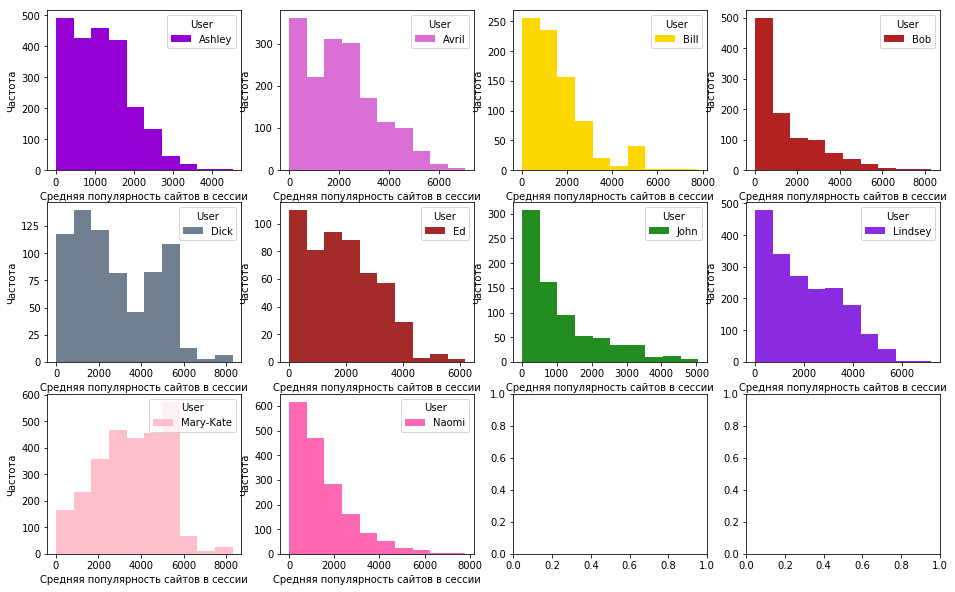

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
row = 0
col = 0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes[row,col].hist(sub_df['mean frequency'],color=color_dic[user])
    axes[row,col].legend([user],title='User')
    axes[row,col].set_xlabel(u'Средняя популярность сайтов в сессии')
    axes[row,col].set_ylabel(u'Частота');
    col += 1
    if col == 4:
        row += 1
        col = 0

C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


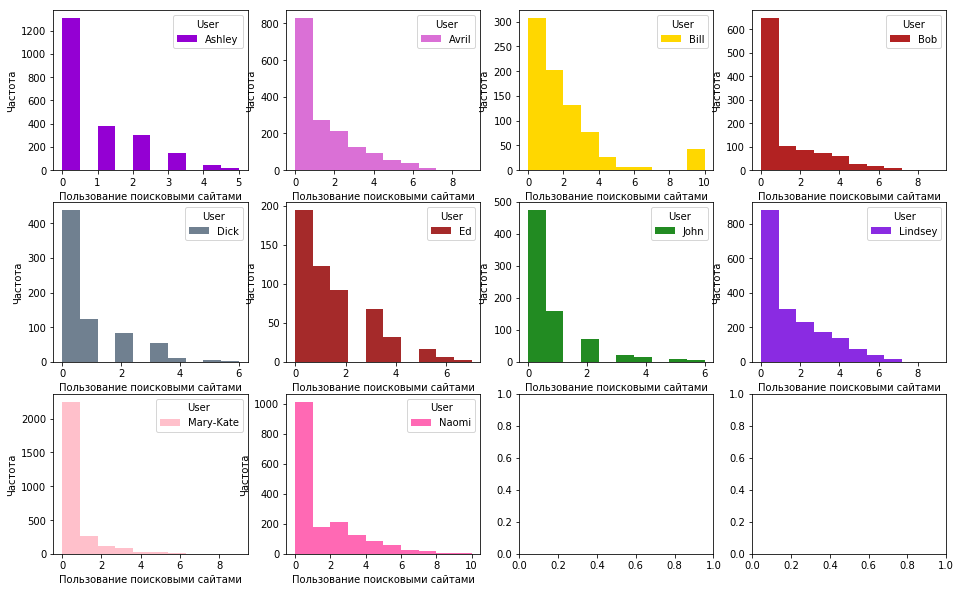

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
row = 0
col = 0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes[row,col].hist(sub_df['search engines'],color=color_dic[user])
    axes[row,col].legend([user],title='User')
    axes[row,col].set_xlabel(u'Пользование поисковыми сайтами')
    axes[row,col].set_ylabel(u'Частота');
    col += 1
    if col == 4:
        row += 1
        col = 0

C:\Users\emorozov\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


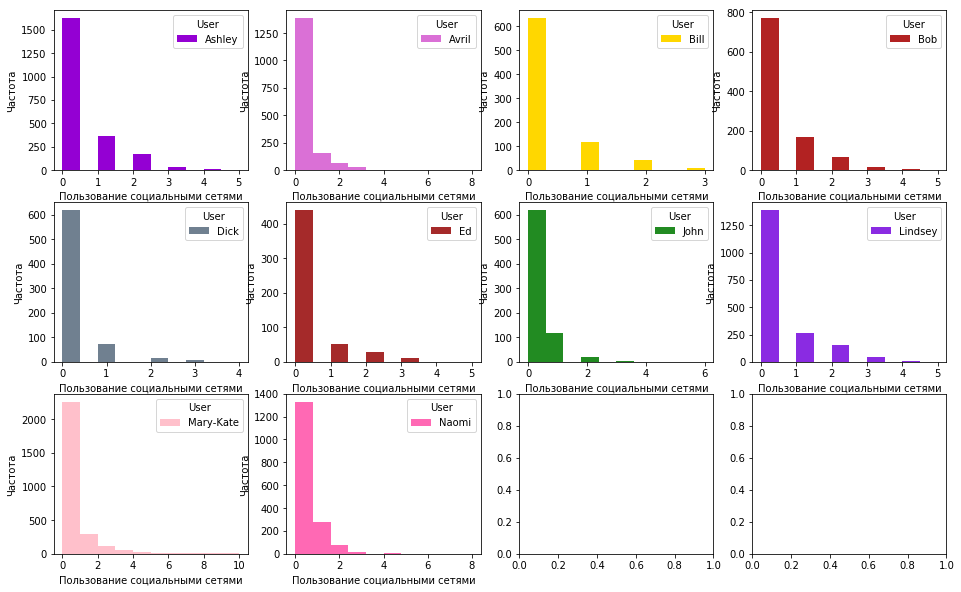

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
row = 0
col = 0
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes[row,col].hist(sub_df['social_network_sites'],color=color_dic[user])
    axes[row,col].legend([user],title='User')
    axes[row,col].set_xlabel(u'Пользование социальными сетями')
    axes[row,col].set_ylabel(u'Частота');
    col += 1
    if col == 4:
        row += 1
        col = 0

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [66]:
selected_features_10users = new_features_10users[['session_timespan','#unique_sites','start_hour','day_of_week','user_id',
                                                 'mean frequency','search engines']]
selected_features_150users = new_features_150users[['session_timespan','#unique_sites','start_hour','day_of_week','user_id',
                                                 'mean frequency','search engines']]

In [67]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 